# Search for orientation of image of HD160617 with astrometry.net


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : October 5th 2021
- update : October 7th 2021 : run spectractor
- version v0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 

# Scan

    # wide scan : HD 160617 
    # all_myseq_holo=range(234,310)
    # narrow scan :  HD 160617 
    # all_myseq_holo=range(317,365)


# Imports

In [55]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [56]:
from iminuit import Minuit
import iminuit

In [57]:
iminuit.__version__

'2.7.0'

In [58]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [59]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [60]:
from distutils.dir_util import copy_tree

In [61]:
from astropy.visualization import simple_norm

In [62]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [63]:
from astroquery.simbad import Simbad
#import astropy.coordinates as coord

import astropy.units as u

In [64]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.table import Table

# Configuration

In [65]:
version="v4.0"

In [66]:
FLAG_REMOVE_WCS=False

In [67]:
FLAG_RUNSPECTRACTOR=False

# Path

In [68]:
# path index for each month
DATE="2021-07-07"
DATE2="2021_07_07"

In [69]:
# select if we run at CC or not (locally) 
HOSTCC=False

In [70]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp/"+DATE)
    path_images2=os.path.join(path_auxtel,"data/2021/holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"data/2021/holo/OutputSpectractor/"+DATE)
    
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp/"+DATE)
    path_images2=os.path.join(path_auxtel,"holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)

# Utility Functions

In [71]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [72]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

In [73]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [74]:
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_'+ version +'.csv'

In [75]:
df=pd.read_csv(filename_logbook,index_col=0)

In [76]:
pd.set_option('display.max_rows', None)

In [77]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-07-08T02:50:31.569,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000234_quick...,234,HD160617,RG610,holo4_003,1.022300,5.0,...,12.1,6.0,3.8,600.0,1900.0,NaN,NaN,,1.0,1.0
1,1,2021-07-08T02:51:12.101,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000235_quick...,235,HD160617,RG610,holo4_003,1.022020,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
2,2,2021-07-08T02:51:21.256,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000236_quick...,236,HD160617,RG610,holo4_003,1.021958,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
3,3,2021-07-08T02:51:30.934,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000237_quick...,237,HD160617,RG610,holo4_003,1.021893,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
4,4,2021-07-08T02:51:40.885,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000238_quick...,238,HD160617,RG610,holo4_003,1.021826,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
5,5,2021-07-08T02:51:50.381,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000239_quick...,239,HD160617,RG610,holo4_003,1.021763,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
6,6,2021-07-08T02:51:59.759,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000240_quick...,240,HD160617,RG610,holo4_003,1.021700,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
7,7,2021-07-08T02:52:10.113,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000241_quick...,241,HD160617,RG610,holo4_003,1.021631,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
8,8,2021-07-08T02:52:19.262,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000242_quick...,242,HD160617,RG610,holo4_003,1.021572,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
9,9,2021-07-08T02:52:29.022,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000243_quick...,243,HD160617,RG610,holo4_003,1.021508,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0


# Selection of input file
- the input file is selected from the logbook list above

In [78]:
# wide scan : HD 160617 
# all_myseq_holo=range(234,310)

# narrow scan :  HD 160617 
# all_myseq_holo=range(317,365)

In [79]:
#idx=76
#idx=96
#idx=109
idx=76 # beginning of narrow scan

In [80]:
target_name=df.iloc[idx]['object']
disperser_name=df.iloc[idx]['disperser']
filename_name=df.iloc[idx]['file']

In [81]:
sky_coord_target=SkyCoord.from_name(target_name)
sky_coord_target

<SkyCoord (ICRS): (ra, dec) in deg
    (265.705515, -40.32097381)>

In [82]:
print(df.iloc[idx]['file'])

holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits


In [83]:
print(df.iloc[idx])

index                                                         76
date                                     2021-07-08T04:49:32.013
path           /Users/dagoret/DATA/AuxTelData2021/holo/quickL...
file           holo4_003_empty_HD160617_20210707_000317_quick...
num                                                          317
object                                                  HD160617
filter                                                   empty_1
disperser                                              holo4_003
airmass                                                 1.065945
exposure                                                    20.0
focus                                                  -1.577194
seeing                                                       NaN
pressure                                                  742.25
temperature                                                 12.3
humidity                                                     6.0
windspd                  

In [84]:
myhome=os.getenv("HOME")

In [85]:
dir_images=path_images

In [86]:
filename_image=df['file'][idx]
filename_image

'holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'

In [87]:
file_target(filename_image)

'HD160617'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [88]:
x0=df['Obj-posXpix'][idx]
y0=df['Obj-posYpix'][idx]

In [89]:
FLAG_ORDER0_LOCATION=False

In [90]:
if not is_nan(x0)and not is_nan(y0):
    FLAG_ORDER0_LOCATION=True
    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

Order 0 location from logbook : (500.0,1900.0)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [91]:
filename_image.split(".")[0]

'holo4_003_empty_HD160617_20210707_000317_quickLookExp'

In [92]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07'

In [93]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
subdir=filename_image.split(".")[0]

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)

# local directories to put spectra and plots
output_directory="./outputs_process_holo_scan"
output_figures="figures_process_holo_scan"

# Final output directory


guess = [250,2600]
disperser_label = "holo4_003"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)

# configuration

# standard spectractor init configuration
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

target = file_target(filename_image)[0]

In [94]:
finalpath_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp'

# Configuration of the Spectractor running mode

In [95]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [96]:
#parameters.DISPERSER_DIR = os.path.join(spectractor_dir, "extractor/dispersers/")
#parameters.CONFIG_DIR = os.path.join(spectractor_dir, "../config/")
#parameters.THROUGHPUT_DIR = os.path.join(spectractor_dir, "simulation/CTIOThroughput/")

# Transform the input file

- the image fits format extracted from quickLookExp images at NCSA has not the exact format required by Spectractor.

In [97]:
from shutil import copyfile

In [98]:
copyfile(filename,filename_image)

'holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'

In [99]:
from astropy.io import fits

In [100]:
hdu = fits.open(filename_image)

In [101]:
hdu.info()

Filename: holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   (4072, 4000)   float32   


In [102]:
# extract header and the image
header=hdu[0].header
image=hdu[0].data

In [103]:
hdu.close()

In [104]:
image

array([[16.485096 , 22.094318 , 41.340862 , ...,  0.6917982, 24.610363 ,
        18.026243 ],
       [20.899769 , 24.499472 , 51.075813 , ...,  8.088775 , 12.498293 ,
        24.48839  ],
       [27.103    , 31.205654 , 45.93318  , ..., 15.702645 , 19.258863 ,
        16.01064  ],
       ...,
       [27.337494 , 47.14983  , 38.81271  , ...,  4.5205073,  2.865673 ,
        12.624642 ],
       [14.872964 , 12.005235 , 27.449303 , ..., -9.388696 ,  9.680872 ,
        -3.481244 ],
       [14.731406 , 39.91549  , 40.331028 , ..., -7.780009 , -2.081829 ,
        16.665905 ]], dtype=float32)

## Rotate image

- rotate the image according what is expected in Spectractor

In [105]:
#rot_image=np.flip(np.flip(image, 1), 0)
rot_image=np.flip(image, 0)

### Remove WCS

- may not be necessary

In [106]:
if FLAG_REMOVE_WCS:
    del header['WCSAXES']
    del header['CTYPE1']
    del header['CTYPE2']
    del header['CUNIT1']
    del header['CUNIT2']
    del header['CRVAL1']
    del header['CRVAL2']
    del header['CRPIX1']
    del header['CRPIX2']

### Put HASTART in hours units

In [107]:
header["HASTART"]=header["HAEND"]  # Spectractor search for HASTART in Hour

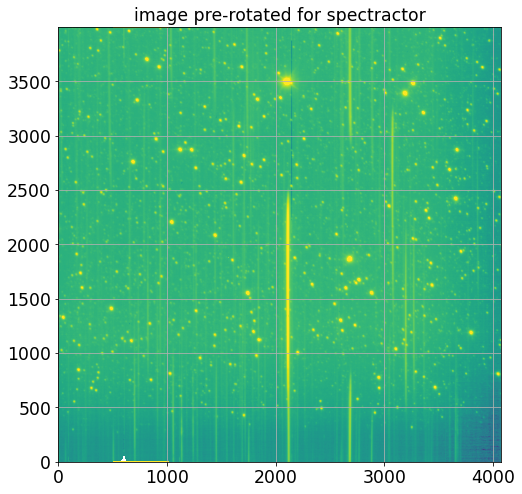

In [108]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
ax.imshow(rot_image,origin="lower",norm=LogNorm(0.1,1000))
ax.grid()
ax.set_title("image pre-rotated for spectractor")
plt.show()

## Reshape the file for load_image_AUXTEL() in Spectractor/spectractor/extractor/images.py

In [109]:
primary_hdu = fits.PrimaryHDU(header=header)
image_hdu = fits.ImageHDU(rot_image)

In [110]:
hdu_list = fits.HDUList([primary_hdu, image_hdu])

In [111]:
hdu_list.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   ()      
  1                1 ImageHDU         7   (4072, 4000)   float32   


In [112]:
hdu_list.writeto(filename_image,overwrite=True)

# Check new version

In [114]:
filename_image

'holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'

In [115]:
fullfilename2=os.path.join( path_images2,filename_image)

In [116]:
hdu2 = fits.open(fullfilename2)

In [117]:
hdu2.info()

Filename: /Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   ()      
  1                1 ImageHDU         7   (4072, 4000)   float32   


In [121]:
# extract header and the image
header2=hdu2[0].header
image2=hdu2[1].data

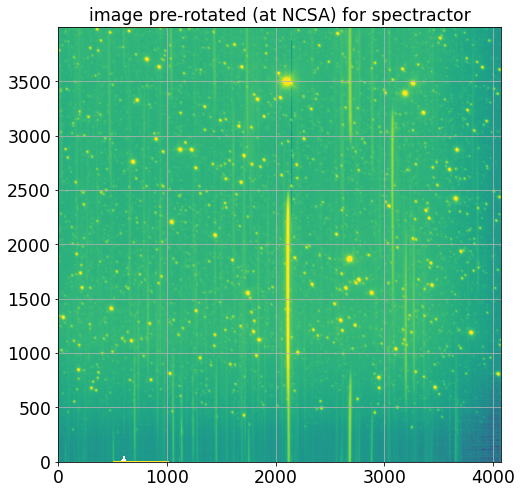

In [123]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
ax.imshow(image2,origin="lower",norm=LogNorm(0.1,1000))
ax.grid()
ax.set_title("image pre-rotated (at NCSA) for spectractor")
plt.show()

## Load the image in the new image file with Spectractor

In [124]:
#image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)
image=Image(file_name=fullfilename2, target_label=target, disperser_label=disperser_label, config=config)

## Show relevant parameters

In [125]:
parameters.OBS_NAME

'AUXTEL'

In [126]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [127]:
parameters.DISTANCE2CCD

182.0

In [128]:
parameters.LAMBDA_MIN 

300

In [129]:
parameters.LAMBDA_MAX 

1100

In [130]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [131]:
image.filter_label

''

In [132]:
image.header["FILTER"]

'empty_1'

In [133]:
image.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-07-08T04:49:17.885'                                             
DATE-OBS= '2021-07-08T04:49:17.885'                                             
DATE-BEG= '2021-07-08T04:49:32.013'                                             
DATE-END= '2021-07-08T04:49:52.252'                                             
MJD     =     59403.2009014509                                                  
MJD-OBS =     59403.2010649694                                                  
MJD-BEG =     59403.20106496

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

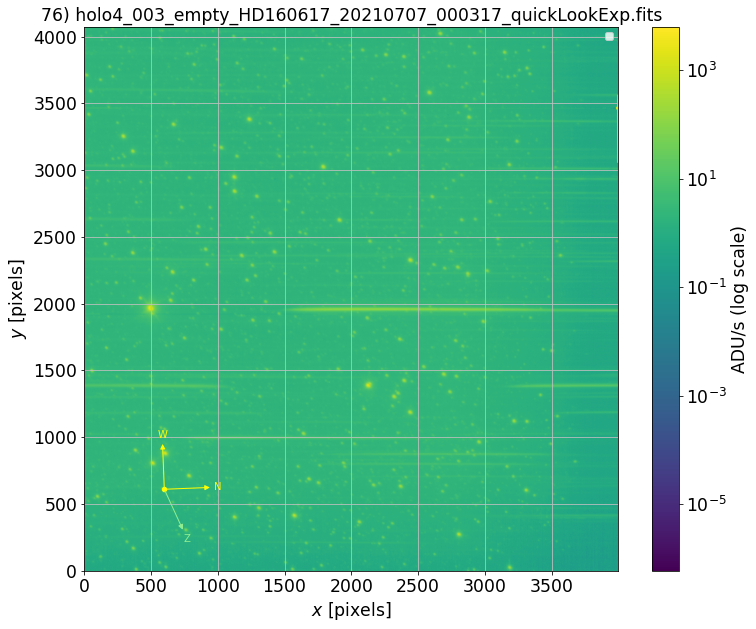

In [134]:
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)

In [135]:
# with filter
guess = [600., 2100.] # filename_image=df['file'][0] , holo4_003_RG610_HD160617_20210707_000234_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][1] , holo4_003_RG610_HD160617_20210707_000235_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][2] , holo4_003_RG610_HD160617_20210707_000236_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][3] , holo4_003_RG610_HD160617_20210707_000237_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][4] , holo4_003_RG610_HD160617_20210707_000238_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][5] , holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][6] , holo4_003_RG610_HD160617_20210707_000240_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][7] , holo4_003_RG610_HD160617_20210707_000241_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][8] , holo4_003_RG610_HD160617_20210707_000242_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][9] , holo4_003_RG610_HD160617_20210707_000243_quickLookExp.fits
guess = [1300., 700.] # filename_image=df['file'][10] , holo4_003_RG610_HD160617_20210707_000244_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][11] , holo4_003_RG610_HD160617_20210707_000245_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][12] , holo4_003_RG610_HD160617_20210707_000246_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][13] , holo4_003_RG610_HD160617_20210707_000247_quickLookExp.fits


# wide scan
guess = [1400., 700.] # filename_image=df['file'][14] , holo4_003_empty_HD160617_20210707_000248_quickLookExp.fits
guess = [1400., 800.] # filename_image=df['file'][15] , holo4_003_empty_HD160617_20210707_000249_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][16] , holo4_003_empty_HD160617_20210707_000250_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][17] , holo4_003_empty_HD160617_20210707_000251_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][18] , holo4_003_empty_HD160617_20210707_000252_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][19] , holo4_003_empty_HD160617_20210707_000253_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][20] , holo4_003_empty_HD160617_20210707_000254_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][21] , holo4_003_empty_HD160617_20210707_000255_quickLookExp.fits

#

# narrrow scan

guess = [500.,2100.] # filename_image=df['file'][76] , 'holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'
guess = [500.,2100.] # filename_image=df['file'][77] , 'holo4_003_empty_HD160617_20210707_000318_quickLookExp.fits'
guess = [500.,1800.] # filename_image=df['file'][78] , 'holo4_003_empty_HD160617_20210707_000319_quickLookExp.fits'
guess = [500.,1800.] # filename_image=df['file'][79] , 'holo4_003_empty_HD160617_20210707_000320_quickLookExp.fits'
guess = [500.,1300.] # filename_image=df['file'][80] , 'holo4_003_empty_HD160617_20210707_000321_quickLookExp.fits'

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [136]:
filename_image

'holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'

In [137]:
# overwrite if localtion is taken from that in logbook
if FLAG_ORDER0_LOCATION : 
    print("Set Order 0 location from logbook : ({},{})".format(x0,y0))
    guess = [x0,y0]

Set Order 0 location from logbook : (500.0,1900.0)


# Open image in astropy

In [138]:
sky_coord_target

<SkyCoord (ICRS): (ra, dec) in deg
    (265.705515, -40.32097381)>

In [139]:
hdu = fits.open(filename_image)

In [140]:
header=hdu[0].header
image=hdu[1].data

In [141]:
wcs = WCS(header)

2021-10-13 17:09:07  astroquery _showwarning         WARNING FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2021-10-13 17:09:07  astroquery _showwarning         WARNING FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -70.749417 from OBSGEO-[XYZ].
Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'.


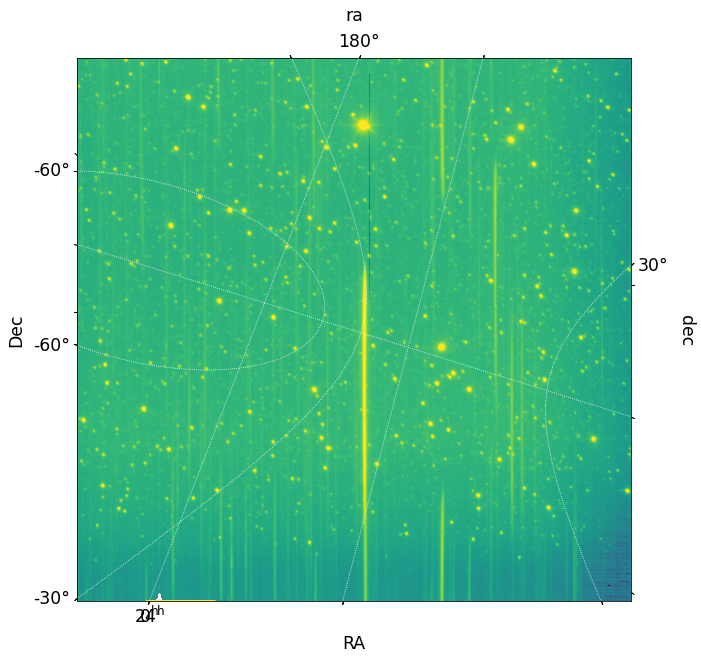

In [142]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs)
plt.imshow(image, aspect='equal',norm=LogNorm(0.1,1000))
plt.xlabel(r'RA')
plt.ylabel(r'Dec')

overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

# Work with astrometry.net

In [186]:
FLAG_RESULTS_ASTROMETRY_NET=True
#DIR_RESULT_ASTROMETRY_NET="astrometry_HD160617"
DIR_RESULT_ASTROMETRY_NET="astrometry_HD160617_20210707_000317"

In [187]:
file_new_image=fullfilename2 # New FITS image
file_axy="axy.fits"             # Stars detected in your images (x,y table) 
file_wcs="wcs.fits"             # WCS file
file_corr="corr.fits"           # Correspondences between image and reference stars
file_rdls="rdls.fits"           # Reference stars nearby (RA,Dec table):

In [188]:
fullfile_new_image=os.path.join(DIR_RESULT_ASTROMETRY_NET,file_new_image)
fullfile_wcs=os.path.join(DIR_RESULT_ASTROMETRY_NET,file_wcs)
fullfile_axy=os.path.join(DIR_RESULT_ASTROMETRY_NET,file_axy)
fullfile_rdls=os.path.join(DIR_RESULT_ASTROMETRY_NET,file_rdls)
fullfile_corr=os.path.join(DIR_RESULT_ASTROMETRY_NET,file_corr)

## The astrometry.net image

In [189]:
if FLAG_RESULTS_ASTROMETRY_NET:
    hdu = fits.open(fullfile_new_image)
    hdu.info()

Filename: /Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   ()      
  1                1 ImageHDU         7   (4072, 4000)   float32   


In [190]:
if FLAG_RESULTS_ASTROMETRY_NET:
    header=hdu[0].header
    image=hdu[0].data
    wcs = WCS(header)
    print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 265.705514583333  -40.3209736111111  
CRPIX : 2000.0  2036.0  
CD1_1 CD1_2  : -0.0262654835694237  -0.101661813739793  
CD2_1 CD2_2  : 0.101661813739793  -0.0262654835694237  
NAXIS : 0  0


In [191]:
header["HA"]

1.45576261800153

TypeError: Image data of dtype object cannot be converted to float

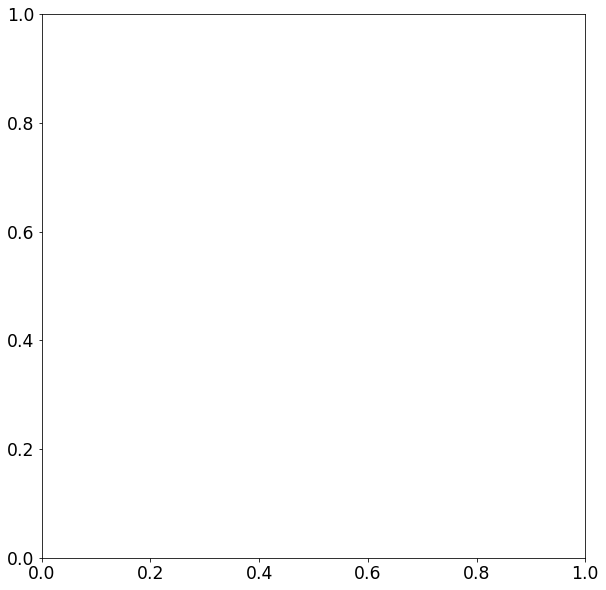

In [192]:
if FLAG_RESULTS_ASTROMETRY_NET:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    ax.imshow(image, origin="lower",aspect='equal',norm=LogNorm(0.1,1000))
    ax.set_xlabel(r' X pixel')
    ax.set_ylabel(r' Y pixel')


    ax.grid(color='white', ls='dotted')
    ax.set_title("image in pixel frame")

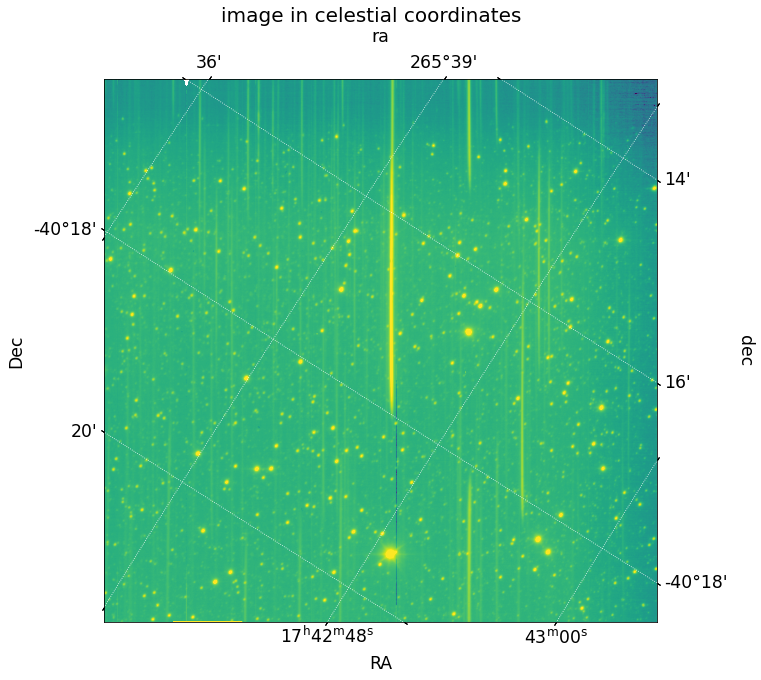

In [150]:
if FLAG_RESULTS_ASTROMETRY_NET:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(projection=wcs)
    ax.imshow(image, aspect='equal',norm=LogNorm(0.1,1000))
    ax.set_xlabel(r'RA')
    ax.set_ylabel(r'Dec')

    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted')
    
    plt.suptitle("image in celestial coordinates",fontsize=20)
    

## WCS coordinates

In [151]:
if FLAG_RESULTS_ASTROMETRY_NET:
    hdu_wcs = fits.open(fullfile_wcs)
    hdu_wcs.info()
    hdu = hdu_wcs[0]
    wcs_astrometry = WCS(hdu.header)
    print(wcs_astrometry)

Filename: astrometry_HD160617_20210707_000317/wcs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     108   ()      


2021-10-13 17:09:13  astroquery _showwarning         WARNING FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 265.672045598  -40.2863189557  
CRPIX : 2059.14883423  2172.0  
CD1_1 CD1_2  : 2.23054782633e-05  -1.43621776819e-05  
CD2_1 CD2_2  : 1.43670029616e-05  2.24193903e-05  
NAXIS : 0  0


## Stars detected in your images (x,y table) 

In [152]:
if FLAG_RESULTS_ASTROMETRY_NET:
    hdu_axy = fits.open(fullfile_axy)
    hdu_axy.info()

Filename: astrometry_HD160617_20210707_000317/axy.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   ()      
  1                1 BinTableHDU     16   1000R x 4C   [E, E, E, E]   


In [153]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_axy = Table.read(fullfile_axy, hdu=1)  

In [154]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_axy.show_in_notebook()
    print(t_axy)

    X         Y        FLUX   BACKGROUND
--------- --------- --------- ----------
2102.1733 490.17886  45480.18   49.53125
    607.5    3995.5 43542.215  14.925781
 3189.499  607.4017  35432.55  45.777344
2681.6384 2128.5605 35349.723  47.972656
3655.6912 1575.3855 11881.081  32.444336
3797.0625 2808.2886  9613.604  26.808594
689.57275 1238.0763   8673.85  39.436523
1045.5264 1792.1743  7442.016   41.84961
 2597.775  2695.083 4192.8486   47.25244
2111.1047 507.48242 31485.137   49.41797
      ...       ...       ...        ...
 766.2161 2996.4585 30.231209   42.22135
3245.7375 1733.8193 71.261536   44.52919
2242.3354  762.2432  69.17494  43.466423
 2720.133 663.88916 64.684555   47.67588
2545.0247 2134.5913  56.45695  46.812176
1283.9357 19.354795 56.736332   43.63094
177.47678 1660.3239   58.0836  39.447437
2513.5146  2821.219 31.842278  46.191345
3371.1707  3502.031 34.516876  23.083504
 871.6149 3331.7314 30.006031  32.903294
3925.1963 1674.3885  75.11845  22.920128
Length = 1000 ro

##  Reference stars nearby (RA,Dec table):

In [155]:
if FLAG_RESULTS_ASTROMETRY_NET:
    hdu_rdls = fits.open(fullfile_rdls)
    hdu_rdls.info()

Filename: astrometry_HD160617_20210707_000317/rdls.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   ()      
  1                1 BinTableHDU     16   40R x 2C   [1D, 1D]   


In [156]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_rdls = Table.read(fullfile_rdls, hdu=1)  

In [157]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_rdls.show_in_notebook()
    print(t_rdls)

        RA                 DEC        
       deg                 deg        
------------------ -------------------
 265.7057130599642  -40.32001861689888
 265.7379194510254  -40.30591111337093
265.71133890324006  -40.23501944438766
265.70132500591876 -40.317644428394615
 265.6344333456929  -40.26036387208002
 265.6575694316007  -40.25176665075496
265.67804444443834  -40.24989722464883
265.72970000843037 -40.276633319026196
265.61735554669616 -40.291336127968776
 265.6731638926823  -40.24340554995668
               ...                 ...
 265.7600777685953  -40.29316388503898
265.68124165038796  -40.32390834714365
 265.7362527767159   -40.2987055585179
 265.7081472096811  -40.26223334263313
 265.6494833328385 -40.326972227859784
265.64086389833665  -40.27216942993895
  265.691148874979 -40.278493342303356
 265.6578500111267  -40.28463331761367
 265.6900055587149 -40.272861112379296
 265.6493555412315 -40.309463901416876
Length = 40 rows


In [158]:
NrefStars=len(t_rdls)

In [159]:
all_sep=np.zeros(NrefStars)
for idx in np.arange(NrefStars):
    the_ra=t_rdls[idx]['RA']
    the_dec=t_rdls[idx]['DEC']
    skyc=SkyCoord(ra=the_ra, dec=the_dec,frame='icrs',unit=(u.deg, u.deg))
    sep = sky_coord_target.separation(skyc).arcsec 
   
    all_sep[idx]=sep
    
    print(">>>>>>>>>>",the_ra,the_dec,sep)
    result_table = Simbad.query_region(skyc,radius=5./3600. * u.deg)
    if result_table != None :
        print(result_table)
    else:
        print("Reference star not found")
       

>>>>>>>>>> 265.7057130599642 -40.32001861689888 3.4814016702810155


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


 MAIN_ID        RA           DEC      ...  Z_VALUE  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD 160617 17 42 49.3235 -40 19 15.505 ... 0.0003350                1
>>>>>>>>>> 265.7379194510254 -40.30591111337093 104.17731121547622


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:57.1007 -40:18:21.28': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.71133890324006 -40.23501944438766 309.84885595600934


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:50.7213 -40:14:06.07': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.70132500591876 -40.317644428394615 16.61104487930509


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:48.318 -40:19:03.5199': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6344333456929 -40.26036387208002 292.7596196060346


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:32.264 -40:15:37.3099': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6575694316007 -40.25176665075496 281.79708239017845


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:37.8167 -40:15:06.3599': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.67804444443834 -40.24989722464883 266.76488762795043


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:42.7307 -40:14:59.63': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.72970000843037 -40.276633319026196 172.88676533157673


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:55.128 -40:16:35.8799': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.61735554669616 -40.291336127968776 264.5033545816017


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:28.1653 -40:17:28.8101': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6731638926823 -40.24340554995668 293.03913059229166


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:41.5593 -40:14:36.26': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6661833232753 -40.323374984549474 108.29936784155524


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


        MAIN_ID               RA           DEC      ... Z_VALUE SCRIPT_NUMBER_ID
                           "h:m:s"       "d:m:s"    ...                         
----------------------- ------------- ------------- ... ------- ----------------
2MASS J17423946-4019240 17 42 39.4701 -40 19 24.055 ...      --                1
>>>>>>>>>> 265.69402779394187 -40.32380556576873 33.136006098942175


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:46.5667 -40:19:25.7': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6873166673495 -40.25385276990208 246.74948536567595


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:44.956 -40:15:13.87': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6034083200538 -40.304049985492405 286.83790728231065


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:24.818 -40:18:14.5799': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.7496360996528 -40.29385001065416 155.58326467544669


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:59.9127 -40:17:37.86': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.67183056284017 -40.31456665983106 95.29351694744355


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:41.2393 -40:18:52.44': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6855361106894 -40.27290832048829 181.52307174837586


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:44.5287 -40:16:22.47': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.69975557011617 -40.3209444428689 15.808571986290545


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:47.9413 -40:19:15.4': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.59981387533134 -40.285924993399206 316.4421840962684


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:23.9553 -40:17:09.33': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.65894168206563 -40.3010833493378 146.53762087013473


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:38.146 -40:18:03.9001': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.65284721789004 -40.27374723156573 223.19847980602407


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:36.6833 -40:16:25.49': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.67770000885514 -40.26685000593219 209.2800026536787


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:42.648 -40:16:00.66': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6526555639742 -40.276005559167395 217.4189023307563


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:36.6373 -40:16:33.62': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.7342111258029 -40.28369721697403 155.61379896919146


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:56.2107 -40:17:01.31': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.63636388485895 -40.324758320467126 190.2858030471432


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:32.7273 -40:19:29.13': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.69121389246953 -40.26832778377564 193.55099862689792


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:45.8913 -40:16:05.98': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.660030551652 -40.32911110193939 128.22713302719677


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:38.4073 -40:19:44.8': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.7422472350787 -40.27160832611502 204.34082994333002


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:58.1393 -40:16:17.79': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6610139029643 -40.26569442944077 233.52686431658904


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:38.6433 -40:15:56.4999': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.7110694613541 -40.24708334228984 266.44269026689676


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:50.6567 -40:14:49.5': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.7600777685953 -40.29316388503898 180.1689680672269


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:43:02.4187 -40:17:35.39': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.68124165038796 -40.32390834714365 67.4553001810237


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:43.498 -40:19:26.07': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.7362527767159 -40.2987055585179 116.39064728694203


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


  MAIN_ID         RA           DEC      ...  Z_VALUE   SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                            
----------- ------------- ------------- ... ---------- ----------------
V* V533 Sco 17 42 56.7406 -40 17 55.490 ... -0.0000300                1
>>>>>>>>>> 265.7081472096811 -40.26223334263313 211.58917159063841


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:49.9553 -40:15:44.04': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6494833328385 -40.326972227859784 155.29498625324806


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:35.876 -40:19:37.1': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.64086389833665 -40.27216942993895 249.76135360851336


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:33.8073 -40:16:19.8099': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.691148874979 -40.278493342303356 157.9345027505983


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


 MAIN_ID        RA           DEC      ... PM_ERR_ANGLE Z_VALUE SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...     deg                              
--------- ------------- ------------- ... ------------ ------- ----------------
HD 324150 17 42 45.8819 -40 16 42.632 ...           90      --                1
>>>>>>>>>> 265.6578500111267 -40.28463331761367 185.04250122556448


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:37.884 -40:17:04.6799': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6900055587149 -40.272861112379296 178.36389690309406


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:45.6013 -40:16:22.3': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6493555412315 -40.309463901416876 159.62862112347815


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:35.8453 -40:18:34.07': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found


In [160]:
all_sep

array([  3.48140167, 104.17731122, 309.84885596,  16.61104488,
       292.75961961, 281.79708239, 266.76488763, 172.88676533,
       264.50335458, 293.03913059, 108.29936784,  33.1360061 ,
       246.74948537, 286.83790728, 155.58326468,  95.29351695,
       181.52307175,  15.80857199, 316.4421841 , 146.53762087,
       223.19847981, 209.28000265, 217.41890233, 155.61379897,
       190.28580305, 193.55099863, 128.22713303, 204.34082994,
       233.52686432, 266.44269027, 180.16896807,  67.45530018,
       116.39064729, 211.58917159, 155.29498625, 249.76135361,
       157.93450275, 185.04250123, 178.3638969 , 159.62862112])

In [161]:
idx_target=np.where(all_sep==np.min(all_sep))[0][0]
idx_target

0

## Correspondences between image and reference stars

In [162]:
if FLAG_RESULTS_ASTROMETRY_NET:
    hdu_corr = fits.open(fullfile_corr)
    hdu_corr.info()

Filename: astrometry_HD160617_20210707_000317/corr.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     47   38R x 13C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1J, 1J, 1D, 1E, 1E]   


In [163]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_corr = Table.read(fullfile_corr, hdu=1)  

In [164]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_corr.show_in_notebook()
    print(t_corr)

     field_x            field_y       ...    FLUX   BACKGROUND
      pixels             pixels       ...                     
------------------ ------------------ ... --------- ----------
 2681.638427734375     2128.560546875 ... 35349.723  47.972656
 3655.691162109375  1575.385498046875 ... 11881.081  32.444336
         3797.0625   2808.28857421875 ...  9613.604  26.808594
   689.57275390625 1238.0762939453125 ...   8673.85  39.436523
   1045.5263671875   1792.17431640625 ...  7442.016   41.84961
  2597.77490234375    2695.0830078125 ... 4192.8486   47.25244
 3263.176025390625  514.0828247070312 ...  19984.76   45.06836
1743.9759521484375    2444.5595703125 ...  9791.027  47.479492
 2882.548583984375   2443.02197265625 ... 7589.6987  48.907715
 48.50725555419922  2669.001220703125 ... 3269.9905  42.622803
               ...                ... ...       ...        ...
 398.0814208984375 1518.8660888671875 ...  624.2851  40.001587
  1709.78369140625  3569.247802734375 ... 1181.5518  25

In [165]:
t_corr.show_in_notebook()

idx,field_x,field_y,field_ra,field_dec,index_x,index_y,index_ra,index_dec,index_id,field_id,match_weight,FLUX,BACKGROUND
,pixels,pixels,degrees,degrees,pixels,pixels,degrees,degrees,none,none,none,,
0,2681.638427734375,2128.560546875,265.6911159019979,-40.27835491774279,2679.6269136205515,2123.6677769651337,265.691148874979,-40.278493342303356,36,3,0.996979165988511,35349.723,47.972656
1,3655.691162109375,1575.385498046875,265.73035453789635,-40.27682061775884,3643.662888753968,1591.339330474017,265.72970000843037,-40.276633319026196,7,4,0.9866942690973651,11881.081,32.444336
2,3797.0625,2808.28857421875,265.7110381003461,-40.24717396131432,3799.657627452592,2810.6564351122674,265.7110694613541,-40.24708334228984,29,5,0.9896868759596621,9613.604,26.808594
3,689.57275390625,1238.0762939453125,265.6495085107226,-40.32705317613769,690.5447709673713,1241.0464929632446,265.6494833328385,-40.326972227859784,34,6,0.9887990512461734,8673.85,39.436523
4,1045.5263671875,1792.17431640625,265.64960822559385,-40.309428065447996,1038.6322671752532,1795.0055908782829,265.6493555412315,-40.309463901416876,39,7,0.9927042214306764,7442.016,41.84961
5,2597.77490234375,2695.0830078125,265.67790461764696,-40.266885855234165,2593.631860542852,2699.3783500827108,265.67770000885514,-40.26685000593219,21,8,0.9959111574856783,4192.8486,47.25244
6,3263.176025390625,514.0828247070312,265.7385390626782,-40.306464076583964,3259.15685068356,540.9416594827337,265.7379194510254,-40.30591111337093,1,10,0.9782298842363918,19984.76,45.06836
7,1743.9759521484375,2444.5595703125,265.65771174228706,-40.284744452869326,1749.6215902827685,2445.932101158274,265.6578500111267,-40.28463331761367,37,11,0.9961166406490779,9791.027,47.479492
8,2882.548583984375,2443.02197265625,265.6910602934053,-40.26843109941879,2888.3776603563265,2443.905907111139,265.69121389246953,-40.26832778377564,25,13,0.9959338066936643,7589.6987,48.907715


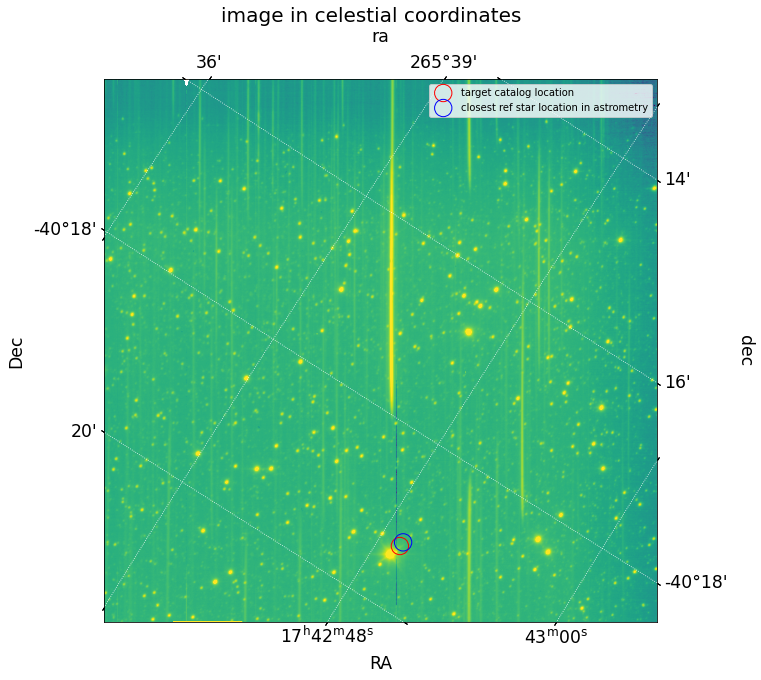

In [166]:
if FLAG_RESULTS_ASTROMETRY_NET:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(projection=wcs)
    ax.imshow(image, aspect='equal',norm=LogNorm(0.1,1000))
    ax.set_xlabel(r'RA')
    ax.set_ylabel(r'Dec')

    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted')

    ax.scatter(sky_coord_target.ra.deg,sky_coord_target.dec.deg, transform=ax.get_transform('icrs'), s=300,edgecolor='red', facecolor='none',label="target catalog location")
    ax.scatter(t_rdls[idx_target]["RA"],t_rdls[idx_target]["DEC"], transform=ax.get_transform('icrs'), s=300,edgecolor='blue', facecolor='none',label="closest ref star location in astrometry")

    ax.legend()
    
    plt.suptitle("image in celestial coordinates",fontsize=20)

In [167]:
NrefStars=len(t_corr)
NrefStars

38

In [168]:
all_sep=np.zeros(NrefStars)+9999
for idx in np.arange(NrefStars):
    
    the_ra=t_corr[idx]['field_ra']
    the_dec=t_corr[idx]['field_dec']
    skyc=SkyCoord(ra=the_ra, dec=the_dec,frame='icrs',unit=(u.deg, u.deg))
    sep = sky_coord_target.separation(skyc).arcsec 
   
    all_sep[idx]=sep
    
    print(">>>>>>>>>>",idx," ra=",the_ra," dec=",the_dec," sep=",sep)
    result_table = Simbad.query_region(skyc,radius=5./3600. * u.deg)
    if result_table != None :
        print(result_table)
    else:
        print("Reference star not found")
       

>>>>>>>>>> 0  ra= 265.6911159019979  dec= -40.27835491774279  sep= 158.43966391333632


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


 MAIN_ID        RA           DEC      ... PM_ERR_ANGLE Z_VALUE SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...     deg                              
--------- ------------- ------------- ... ------------ ------- ----------------
HD 324150 17 42 45.8819 -40 16 42.632 ...           90      --                1
>>>>>>>>>> 1  ra= 265.73035453789635  dec= -40.27682061775884  sep= 172.96505764590302


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:55.2851 -40:16:36.5542': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 2  ra= 265.7110381003461  dec= -40.24717396131432  sep= 266.11207406369226


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:50.6491 -40:14:49.8263': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 3  ra= 265.6495085107226  dec= -40.32705317613769  sep= 155.26727077979066


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:35.882 -40:19:37.3914': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 4  ra= 265.64960822559385  dec= -40.309428065447996  sep= 158.9925997774951


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:35.906 -40:18:33.941': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 5  ra= 265.67790461764696  dec= -40.266885855234165  sep= 208.95534527166777


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:42.6971 -40:16:00.7891': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 6  ra= 265.7385390626782  dec= -40.306464076583964  sep= 104.62505499637878


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:57.2494 -40:18:23.2707': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 7  ra= 265.65771174228706  dec= -40.284744452869326  sep= 185.02885114615145


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:37.8508 -40:17:05.08': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 8  ra= 265.6910602934053  dec= -40.26843109941879  sep= 193.27297581308042


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:45.8545 -40:16:06.352': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 9  ra= 265.604490243575  dec= -40.30413726442561  sep= 283.8689633070211


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:25.0777 -40:18:14.8942': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 10  ra= 265.65252318004946  dec= -40.27368066718734  sep= 223.95811659578732


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:36.6056 -40:16:25.2504': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 11  ra= 265.689903363833  dec= -40.272802595510186  sep= 178.6356018271173


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:45.5768 -40:16:22.0893': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 12  ra= 265.73629785353256  dec= -40.29892397638587  sep= 115.94053476616219


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


  MAIN_ID         RA           DEC      ...  Z_VALUE   SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                            
----------- ------------- ------------- ... ---------- ----------------
V* V533 Sco 17 42 56.7406 -40 17 55.490 ... -0.0000300                1
>>>>>>>>>> 13  ra= 265.6589347916082  dec= -40.300973111122126  sep= 146.7485266410953


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:38.1443 -40:18:03.5032': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 14  ra= 265.6934792777318  dec= -40.32361675807697  sep= 34.377351853759166


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:46.435 -40:19:25.0203': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 15  ra= 265.67810208569153  dec= -40.2501288180319  sep= 265.9203961251714


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:42.7445 -40:15:00.4637': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 16  ra= 265.66073956334856  dec= -40.26594959221684  sep= 233.14081939674082


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:38.5775 -40:15:57.4185': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 17  ra= 265.6849480884476  dec= -40.27282996297039  sep= 182.2856975183877


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:44.3875 -40:16:22.1879': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 18  ra= 265.7110412232676  dec= -40.23513247863729  sep= 309.40129135045083


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:50.6499 -40:14:06.4769': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 19  ra= 265.70875982368545  dec= -40.26207332323724  sep= 212.228874197918


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:50.1024 -40:15:43.464': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 20  ra= 265.6999804772126  dec= -40.32088773559063  sep= 15.194070238263174


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:47.9953 -40:19:15.1958': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 21  ra= 265.6525368710669  dec= -40.276055756999305  sep= 217.50215827900126


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:36.6088 -40:16:33.8007': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 22  ra= 265.61844768685035  dec= -40.290320025876646  sep= 263.276423648836


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:28.4274 -40:17:25.1521': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 23  ra= 265.73367463025517  dec= -40.2836308378689  sep= 155.08039249784653


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:56.0819 -40:17:01.071': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 24  ra= 265.68774465634203  dec= -40.25374273476677  sep= 246.90244202297004


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:45.0587 -40:15:13.4738': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 25  ra= 265.65953030941694  dec= -40.32874533806809  sep= 129.2731448001367


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:38.2873 -40:19:43.4832': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 26  ra= 265.59970082144406  dec= -40.28592839870739  sep= 316.7219624656294


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:23.9282 -40:17:09.3422': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 27  ra= 265.74883843452557  dec= -40.29362401079  sep= 154.40225013020452


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:59.7212 -40:17:37.0464': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 28  ra= 265.6358946664476  dec= -40.324913609135436  sep= 191.6107229878512


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:32.6147 -40:19:29.689': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 29  ra= 265.6353342048314  dec= -40.26020099543275  sep= 291.55605281305174


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:32.4802 -40:15:36.7236': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 30  ra= 265.6708135942551  dec= -40.243438613445186  sep= 294.94759832012903


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:40.9953 -40:14:36.379': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 31  ra= 265.6572915770523  dec= -40.25142458509259  sep= 283.24252599986505


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:37.75 -40:15:05.1285': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 32  ra= 265.7425778715803  dec= -40.27134006519342  sep= 205.62916568230773


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:58.2187 -40:16:16.8242': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 33  ra= 265.6667632658575  dec= -40.32410404139753  sep= 106.9567808377298


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:40.0232 -40:19:26.7745': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 34  ra= 265.64063115306146  dec= -40.272435092455005  sep= 249.54509054474883


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:33.7515 -40:16:20.7663': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 35  ra= 265.6799273522307  dec= -40.32411438457823  sep= 71.13438854627886


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:43.1826 -40:19:26.8118': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 36  ra= 265.7599335611828  dec= -40.29306543836621  sep= 180.03758361868447


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:43:02.3841 -40:17:35.0356': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 37  ra= 265.67239199995794  dec= -40.31458312397625  sep= 93.78443653195374


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:41.3741 -40:18:52.4992': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found


In [169]:
all_sep

array([158.43966391, 172.96505765, 266.11207406, 155.26727078,
       158.99259978, 208.95534527, 104.625055  , 185.02885115,
       193.27297581, 283.86896331, 223.9581166 , 178.63560183,
       115.94053477, 146.74852664,  34.37735185, 265.92039613,
       233.1408194 , 182.28569752, 309.40129135, 212.2288742 ,
        15.19407024, 217.50215828, 263.27642365, 155.0803925 ,
       246.90244202, 129.2731448 , 316.72196247, 154.40225013,
       191.61072299, 291.55605281, 294.94759832, 283.242526  ,
       205.62916568, 106.95678084, 249.54509054,  71.13438855,
       180.03758362,  93.78443653])

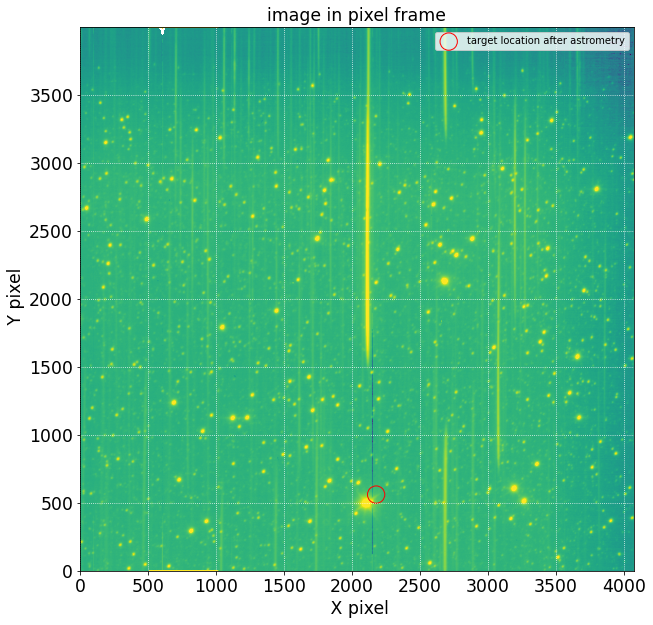

In [170]:
if FLAG_RESULTS_ASTROMETRY_NET:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    ax.imshow(image, origin="lower",aspect='equal',norm=LogNorm(0.1,1000))
    ax.set_xlabel(r' X pixel')
    ax.set_ylabel(r' Y pixel')

    x0, y0 = wcs.world_to_pixel(sky_coord_target)
    ax.scatter(x0,y0, s=300,edgecolor='red', facecolor='none',label="target location after astrometry")

    ax.grid(color='white', ls='dotted')
    ax.set_title("image in pixel frame")
    ax.legend()

# Process Spectractor

In [171]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [172]:
# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
subdir=filename_name.split(".")[0]


# local directories to put spectra and plots
output_directory="./outputs_process_holo_scan_orient"
output_figures="./figures_process_holo_scan_orient"

# Final output directory


guess = [500,2000]
disperser_label = "holo4_003"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)

# configuration

# standard spectractor init configuration
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

target = file_target(filename_image)[0]

In [173]:
! ls -l $fullfile_new_image

-rw-r--r--@ 1 dagoret  staff  65177280 Oct  7 11:34 astrometry_HD160617_20210707_000317/new-image.fits


In [174]:
from shutil import copyfile
copyfile(fullfile_new_image,filename_name)
from astropy.io import fits
hdu = fits.open(filename_name)
hdu.info()
# extract header and the image
header=hdu[0].header
image=hdu[0].data

hdu.close()


primary_hdu = fits.PrimaryHDU(header=header)
image_hdu = fits.ImageHDU(rot_image)
hdu_list = fits.HDUList([primary_hdu, image_hdu])
hdu_list.info()
hdu_list.writeto(filename_name,overwrite=True)

Filename: holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     252   (4072, 4000)   float32   
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     251   ()      
  1                1 ImageHDU         7   (4072, 4000)   float32   


In [175]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4072                                                  
NAXIS2  =                 4000                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-07-08T04:49:17.885'                                             
DATE-OBS= '2021-07-08T04:49:32.013'                                             
DATE-BEG= '2021-07-08T04:49:32.013'                                             
DATE-END= '2021-07-08T04:49:52.252'                                             
MJD     =     59403.2009014509                                                  
MJD-OBS =     59403.20106496

In [176]:
if FLAG_RUNSPECTRACTOR:
    #image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)
    image=Image(file_name=filename_name, target_label=target_name, disperser_label=disperser_name, config=config)

In [177]:
if FLAG_RUNSPECTRACTOR:
    title="{}) {}".format(idx,filename_name)
    image.plot_image(figsize=(12, 10),scale="log",title=title)

In [178]:
if FLAG_RUNSPECTRACTOR:
    parameters.VERBOSE = True
    parameters.DEBUG = True
    #x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
    x1, y1 = find_target(image, guess,rotated=False)

In [179]:
if FLAG_RUNSPECTRACTOR:
    spectrum = Spectractor(filename_name, output_directory, guess=[x1,y1], target_label=target_name, disperser_label=disperser_name, config=config)